In [2]:
!pip install -q -U ultralytics
!pip install -U -q ipywidgets

In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.28 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5643.4/8062.4 GB disk)


In [4]:
import os
import random
import glob
import shutil

import json
import yaml

from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from lxml import etree as ET

import pandas as pd
import matplotlib.pyplot as plt

import cv2
# from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using device: cuda

image 1/1 /kaggle/input/ded-for-pensia/redbull_granny.jpg: 448x640 2 logos, 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Cropped Image 0_0: Closest Image: redbullimg000227_cropped_3.png, Label: redbull_text


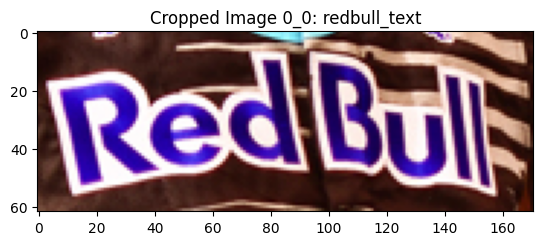

Cropped Image 0_1: Closest Image: redbullimg000608_cropped_34.png, Label: redbull_text


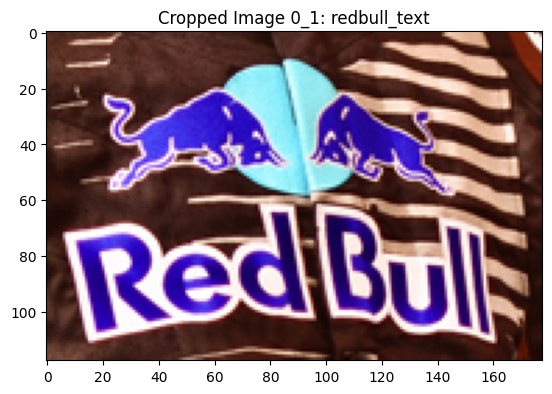

Cropped images and their labels saved to /kaggle/working/


In [18]:
import os
import cv2
import torch
import torch.nn as nn
import pickle
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Ensure you have ultralytics package installed

# Load the pre-trained feature extraction model
model_path = '/kaggle/input/closest-img-model/resnet50_feature_extractor (1).pth'
model = models.resnet50(pretrained=False)
model = nn.Sequential(*list(model.children())[:-1])
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Load pre-computed image features
features_path = '/kaggle/input/extracted-features/image_features.pkl'
with open(features_path, 'rb') as f:
    image_features = pickle.load(f)

# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess an image
def load_and_preprocess_image(image):
    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to extract features from an image
def extract_features(image, model, device):
    img_tensor = load_and_preprocess_image(image).to(device)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()

# Function to find the closest image and its label
def find_closest_image_and_label(cropped_image, image_features, data_folder, model, device):
    input_features = extract_features(cropped_image, model, device)
    similarities = {}
    for file_name, features in image_features.items():
        similarity = cosine_similarity([input_features], [features])[0][0]
        similarities[file_name] = similarity
    
    if not similarities:
        raise ValueError("No similarities found. Ensure that image features are correctly extracted.")
    
    closest_image = max(similarities, key=similarities.get)
    label_file = os.path.splitext(closest_image)[0] + '.txt'
    with open(os.path.join(data_folder, label_file), 'r') as f:
        label = f.read().strip()
    return closest_image, label

# Ensure output directory exists
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Load the YOLOv8 model
yolo_model = YOLO('/kaggle/input/model-det/best.pt')  # Replace with the correct model path if different

# Load the input image and get bounding boxes from YOLO model
#input_image_path = '/kaggle/input/example-img/1008198576.jpg'
input_image_path = '/kaggle/input/ded-for-pensia/redbull_granny.jpg'
input_image = Image.open(input_image_path)
results = yolo_model(input_image_path)

# Directory containing images and annotations
data_folder = '/kaggle/input/classification-data/openlogo_classes_and_logos_only'

cropped_images_list = []

# Process results, crop images, and find labels
for i, result in enumerate(results):
    boxes = result.boxes
    img_cv2 = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)

    for j, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert to integer
        cropped_img_cv2 = img_cv2[y1:y2, x1:x2]
        cropped_img_pil = Image.fromarray(cv2.cvtColor(cropped_img_cv2, cv2.COLOR_BGR2RGB))

        # Find the closest image and its label for the cropped image
        try:
            closest_image, label = find_closest_image_and_label(cropped_img_pil, image_features, data_folder, model, device)

            # Save the cropped image
            output_image_path = os.path.join(output_dir, f'cropped_{i}_{j}.png')
            cropped_img_pil.save(output_image_path)

            # Print the label
            print(f'Cropped Image {i}_{j}: Closest Image: {closest_image}, Label: {label}')

            # Optionally, display the cropped image
            plt.imshow(cropped_img_pil)
            plt.title(f'Cropped Image {i}_{j}: {label}')
            plt.show()
        except Exception as e:
            print(f"Error processing cropped image {i}_{j}: {e}")

print(f'Cropped images and their labels saved to {output_dir}')
